In [19]:
import time
import json
import psutil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from RSA import rsa_decrypt, rsa_encrypt
from RSA_with_blinding import secure_decrypt
from Crypto.Random import get_random_bytes
from Crypto.Util.number import bytes_to_long


In [25]:
def load_rsa_keys_from_json(json_file_path):
    with open(json_file_path, 'r') as file:
        keys = json.load(file)
    # Convert 'n', 'e', and 'd' from strings to integers
    for key_pair in keys:
        key_pair['public_key']['n'] = int(key_pair['public_key']['n'])
        key_pair['public_key']['e'] = int(key_pair['public_key']['e'])
        key_pair['private_key']['n'] = int(key_pair['private_key']['n'])
        key_pair['private_key']['d'] = int(key_pair['private_key']['d'])
    return keys

rsa_keys = load_rsa_keys_from_json('rsa_keys.json')

In [26]:
def monitor_cpu_times():
    # Get the CPU times of the current process
    cpu_times = psutil.Process().cpu_times()
    # Return user + system CPU times to capture the total CPU time consumed by the process
    return cpu_times.user + cpu_times.system


def monitor_performance(decrypt_function, args, num_iterations=500):
    cpu_time_usage = []
    decryption_times = []

    for _ in range(num_iterations):
        # Capture CPU times before decryption
        cpu_time_before = monitor_cpu_times()
        
        # Decryption and time measurement
        start_time = time.perf_counter()
        decrypt_function(*args)
        end_time = time.perf_counter()
        
        # Capture CPU times after decryption
        cpu_time_after = monitor_cpu_times()
        
        # Collect data
        cpu_time_usage.append(cpu_time_after - cpu_time_before)
        decryption_times.append(end_time - start_time)

    return decryption_times, cpu_time_usage


In [30]:
first_key_pair = rsa_keys[0]

public_key = first_key_pair['public_key']
private_key = first_key_pair['private_key']

message_bytes = get_random_bytes(256)  # Generate message as bytes
message_int = bytes_to_long(message_bytes)  # Convert message to integer
ciphertext = rsa_encrypt(public_key, message_int) 


# Perform performance monitoring for rsa_decrypt without blinding
times_without_blinding, cpu_without_blinding = monitor_performance(
    rsa_decrypt, [private_key, ciphertext], num_iterations=100)

# Perform performance monitoring for secure_decrypt with blinding
times_with_blinding, cpu_with_blinding = monitor_performance(
    secure_decrypt, [ciphertext, private_key, public_key], num_iterations=100)




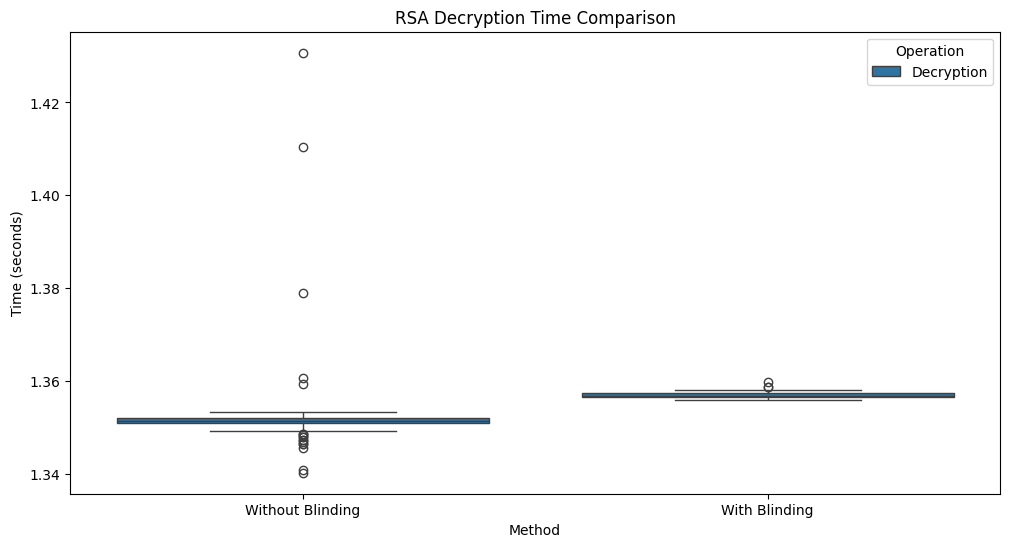

In [32]:
data = {
    'Method': ['Without Blinding'] * len(times_without_blinding) + ['With Blinding'] * len(times_with_blinding),
    'Operation': ['Decryption'] * len(times_without_blinding) + ['Decryption'] * len(times_with_blinding),
    'Time': times_without_blinding + times_with_blinding,
    'CPU Usage (%)': cpu_without_blinding + cpu_with_blinding}
df = pd.DataFrame(data)



# Now plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Time', hue='Operation', data=df)
plt.title('RSA Decryption Time Comparison')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')
plt.show()


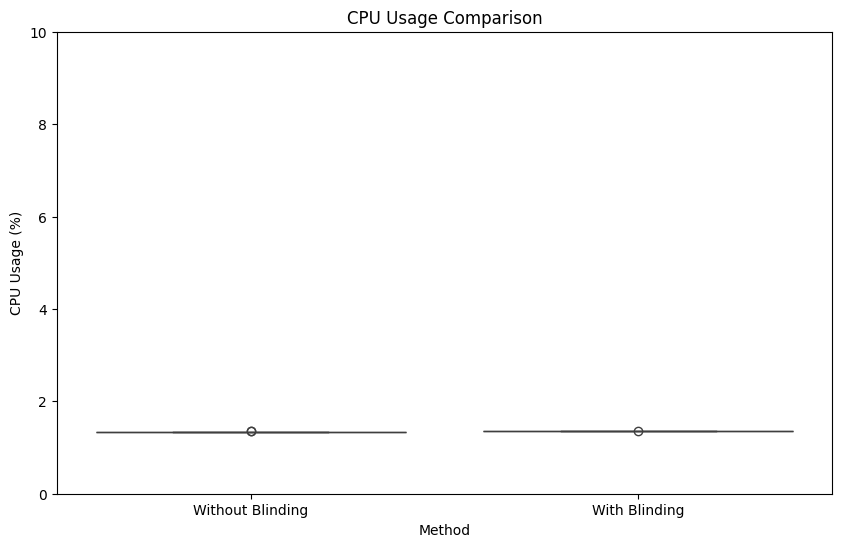

In [29]:
# Plotting CPU Usage
plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='CPU Usage (%)', data=df)
plt.title('CPU Usage Comparison')
plt.ylabel('CPU Usage (%)')
plt.xlabel('Method')
plt.ylim(0, 10)
plt.show()